C:\Users\alex\AppData\Local\Temp\ipykernel_22896\1164836832.py:65: RuntimeWarning: invalid value encountered in sqrt
  frequency_decoupled = np.sqrt((default_properties['k_t'] - default_properties['l_a'] * default_properties['C_t'] * U_vals * U_vals) / default_properties['I'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


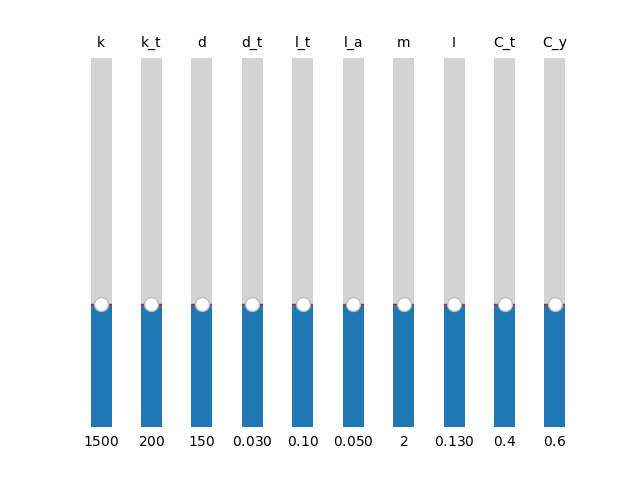

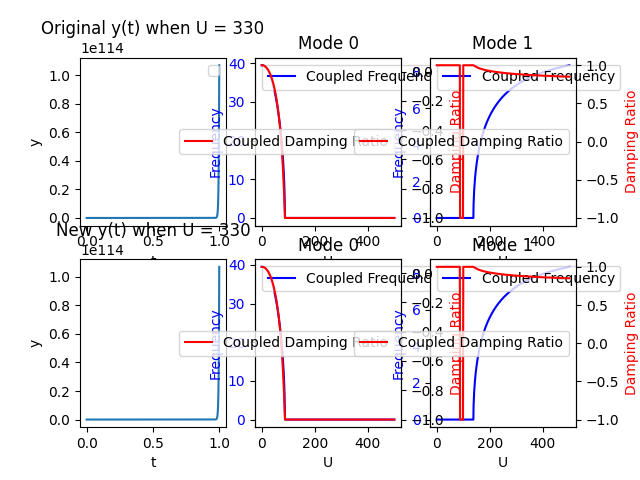

In [16]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider 

from wingsuit import WingsuitProperties, get_modal_properties, simulate

np.set_printoptions(linewidth=200)

default_properties: WingsuitProperties = {
    'k': 1500,
    'k_t': 200,

    'd': 150,
    'd_t': 0.03,
    
    'l_t': 0.1,
    'l_a': 0.05,

    'm': 2,
    'I': 0.13,

    'C_t': 0.4,
    'C_y': 0.6
}

# Part b numerical integration

def part_b():
    fig = plt.figure()
    axis = plt.axes()

    U_values = [240, 260]

    for U in U_values:
        new_properties = default_properties.copy()
        new_properties['l_t'] = 0
        new_properties['C_t'] = 0

        solution = simulate(new_properties, 1, 1, U)

        axis.plot(solution.t, solution.y[1], label=f'y(t) when U = {U}')

    axis.set_xlabel('t')
    axis.set_ylabel('y')
    axis.set_title("Solutions on either side of critical airspeed")
    fig.legend()

# part_b()

# Part C modal analysis

def plot_modes(U_vals, modes, axes, include_decoupled = False):
    lines = []

    for i, mode in enumerate(modes):
        axes[i].set_xlabel('U')
        axes[i].set_title(f"Mode {i}")

        frequency_axis = axes[i]
        damping_axis = frequency_axis.twinx()

        [frequency_line] = frequency_axis.plot(U_vals, mode['frequency'], 'b', label="Coupled Frequency")

        frequency_decoupled = np.sqrt((default_properties['k_t'] - default_properties['l_a'] * default_properties['C_t'] * U_vals * U_vals) / default_properties['I'])

        frequency_axis.set_ylabel(f"Frequency", color='b')
        frequency_axis.tick_params(axis='y', labelcolor='b')

        [damping_line] = damping_axis.plot(U_vals, mode['damping'], 'r', label="Coupled Damping Ratio")

        damping_ratio_decoupled = (default_properties['d'] - default_properties['C_y'] * U_vals) / np.sqrt(default_properties['k'] * default_properties['m'])
        damping_axis.set_ylabel(f"Damping Ratio", color='r')

        if include_decoupled:
            frequency_axis.plot(U_vals, frequency_decoupled, 'b.', label="Decoupled Frequency")
            damping_axis.plot(U_vals, damping_ratio_decoupled, 'r.', label="Decoupled Damping Ratio")

        frequency_axis.legend(loc="upper left")
        damping_axis.legend()

        lines.append({'frequency': frequency_line, 'damping': damping_line})

    return lines

def part_c():
    U_vals = np.linspace(0, 500, 501)

    modes = get_modal_properties(default_properties, U_vals)

    fig, axes = plt.subplots(1, len(modes))

    plot_modes(U_vals, modes, axes, True)

# part_c()

# Part d design modification

def part_d():
    fig, axes = plt.subplots(2, 3)

    U_vals = np.linspace(0, 500, 501)
    
    target_U = 330

    original_solution = simulate(default_properties, 1, 1, target_U)

    modes = get_modal_properties(default_properties, U_vals)

    plot_modes(U_vals, modes, axes[0][1:])

    axes[0][0].plot(original_solution.t, original_solution.y[1])
    axes[0][0].set_xlabel('t')
    axes[0][0].set_ylabel('y')
    axes[0][0].legend()
    axes[0][0].set_title(f'Original y(t) when U = {target_U}')

    new_properties = default_properties.copy()

    new_solution = simulate(new_properties, 1, 1, target_U)
    new_modes = get_modal_properties(new_properties, U_vals)

    mode_lines = plot_modes(U_vals, new_modes, axes[1][1:])

    [response_line] = axes[1][0].plot(new_solution.t, new_solution.y[1])
    axes[1][0].set_xlabel('t')
    axes[1][0].set_ylabel('y')
    axes[1][0].set_title(f'New y(t) when U = {target_U}')

    sliders = {}

    def update(val):
        for key in sliders:
            new_properties[key] = sliders[key].val
        
        new_solution = simulate(new_properties, 1, 1, target_U)
        new_modes = get_modal_properties(new_properties, U_vals)

        response_line.set_data(new_solution.t, new_solution.y[1])
        
        for i, mode in enumerate(mode_lines):
            mode['frequency'].set_ydata(new_modes[i]['frequency'])
            mode['damping'].set_ydata(new_modes[i]['damping'])
        
        fig.canvas.draw_idle()

    fig, control_axes = plt.subplots(1, len(default_properties))

    for i, key in enumerate(default_properties):
        valinit = default_properties[key]

        sliders[key] = Slider(
            ax=control_axes[i],
            label=key,
            valmin=valinit / 2,
            valmax=valinit * 2,
            valinit=valinit,
            orientation='vertical'
        )

        sliders[key].on_changed(update)

part_d()

plt.ion()
plt.show(block=True)

